# Relationships between Loan Characteristics and Chance of Default
## by Ryan Johnson

## Investigation Overview

> In this investigation, I wanted to look at why loans tended to default. The main focus was on LoanStatus, which had several designations, which I combined into Default or Current. Meaning the loan was either current, or in some form of default. All complete loans were dropped. This was then compared against several different categories, such as, ProsperScore, LoanAmount, BorrowerAPR and ListingCategory.

## Dataset Overview

> The original data set consisted of 113,937 loans which was later brought down to 72,555 loans that were still active(not complete). LoanStatus was then compared to several different categories to see if a trend exists as to why loans default.

In [13]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [3]:
# load in the dataset into a pandas dataframe
loans = pd.read_csv('prosperLoanData.csv')

In [4]:
# Remove Null values from object data types
objects = loans.select_dtypes(include=['object']).columns.values
loans[objects] = loans[objects].fillna('Unknown')

In [5]:
# Need to find values for the float64 dtypes or we will lose close to half are data. Lets work through these 1 by 1
# EstimatedEffectiveYeild = BorrowerRate - EstimatedLossFromFees
estimated_loss_from_fees = loans['BorrowerRate'] - loans['EstimatedEffectiveYield']
loans['EstimatedEffectiveYield'].fillna(loans['BorrowerRate'] - estimated_loss_from_fees.median(), inplace=True)
loans['EstimatedEffectiveYield'].isnull().sum()

0

In [6]:
# EstimatedLoss is the estimated pricipal loss on chargeoffs, not a good way to calculate, lets just take the median value.
loans['EstimatedLoss'].fillna(loans['EstimatedLoss'].median(), inplace=True)
loans['EstimatedLoss'].isnull().sum()

0

In [7]:
# EstimatedReturn is the difference between Estimated Effective Yiueld and Estimated Loss Rate
loans['EstimatedReturn'].fillna(loans['EstimatedEffectiveYield'] - loans['EstimatedLoss'], inplace=True)
loans['EstimatedReturn'].isnull().sum()

0

In [8]:
# ProsperRating (numeric) is assigned at the time of loan listing, since we can't calculate, we will just use the median
loans['ProsperRating (numeric)'].fillna(loans['ProsperRating (numeric)'].median(), inplace=True)
loans['ProsperRating (numeric)'].isnull().sum()

0

In [9]:
# ProsperScore is assigned using historic prosper data, since we can't calculate, we will just use the median
loans['ProsperScore'].fillna(loans['ProsperScore'].median(), inplace=True)
loans['ProsperScore'].isnull().sum()

0

In [10]:
# BorrowerAPR is missing 25 values, BorrowerAPR = BorrowerRate + BorrowerFees Lets find the median fees and add it to the BorrowerRate
loans['BorrowerAPR'].fillna(loans['BorrowerRate'] + (loans['BorrowerAPR'] - loans['BorrowerRate']).median(), inplace=True)
loans['BorrowerAPR'].isnull().sum()

0

In [11]:
# The majority of the remaining fields aren't of any real interest to my exploration, I will clean up a few fields by droping
# there missing rows.
loans.dropna(subset=['EmploymentStatusDuration', 'CurrentCreditLines', 'OpenCreditLines', 'AmountDelinquent', 
                     'CreditScoreRangeLower', 'FirstRecordedCreditLine', 'TotalCreditLinespast7years'], inplace=True)

In [16]:
loans['newLoanStatus'] = ['Defaulted' if 'Past' in x else x for x in loans['LoanStatus']]

In [35]:
# Give actual names to the ListingCategory
listingdic = {0:'Not Available', 1: 'Debt Consolidation', 2: 'Home Improvement', 3: 'Business', 4: 'Personal Loan', 
              5: 'Student Use', 6: 'Auto', 7: 'Other', 8: 'Baby&Adoption', 9: 'Boat', 10: 'Cosmetic Procedure', 11: 'Engagement Ring',
              12: 'Green Loans', 13: 'Household Expenses', 14: 'Large Purchases', 15: 'Medical/Dental', 16: 'Motorcycle',
              17: 'RV', 18: 'Taxes', 19: 'Vacation', 20: 'Wedding Loans'}

loans.replace({'ListingCategory (numeric)': listingdic}, inplace=True)
## Don't need the old Column Name of ListingCategory (numeric), lets Change it to ListingCategory
loans.rename(columns={'ListingCategory (numeric)':'ListingCategory'}, inplace=True)

## LoanStatus Breakdown

> Here we can see what the break down of the differing loan statuses are. We can see a strong indication the most loans are current, and a large percentage of loans are complete. Thats why we end up droping those records later. Later we will combine Defaulted, Chargedoff, and Cancelled into the Category Defaulted, and Current, FinalPaymentInProgress as Current.

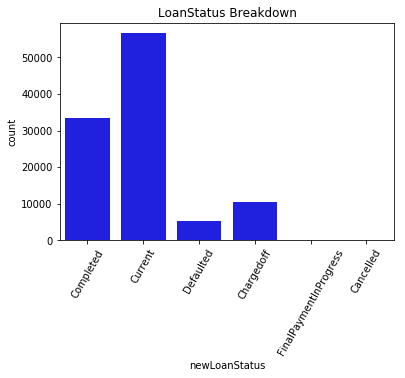

In [36]:
g = sns.countplot(loans['newLoanStatus'], color='blue')
plt.title('LoanStatus Breakdown')
plt.xticks(rotation=60);

## Loans Issued by ProsperScore

> Here we can see that a majority of the loans recieved a Prosper score of 6, Prosper seems to do a fairly good job breaking the loans into varying categories, as it looks like a mirror image folded over the 6 category.

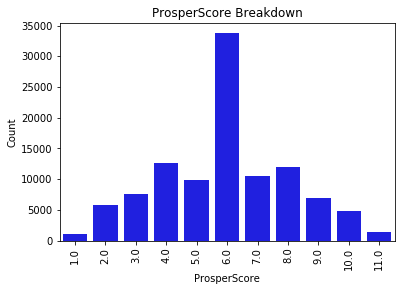

In [37]:
g = sns.barplot(x=loans.ProsperScore.value_counts().index, y=loans.ProsperScore.value_counts(), color='blue')
plt.title('ProsperScore Breakdown')
plt.xlabel('ProsperScore')
plt.ylabel('Count')
plt.xticks(rotation=90);

## Loans Issued by OriginalLoanAmount

> The distribution of loans is Right Skewed as you'd expect, larger loans are harder to get. We can see loans of all different values have been issued, however, we can see several main dollar amounts tend to pop up on $5k increments.

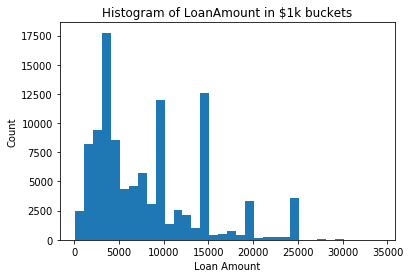

In [38]:
la = plt.hist(loans['LoanOriginalAmount'], bins=np.arange(100,35000,1000))
plt.xlabel('Loan Amount')
plt.ylabel('Count')
plt.title('Histogram of LoanAmount in $1k buckets');

## Loans Issued by OriginalLoanAmount

> Loans of all different values have been issued, however, we can see several man dollar amounts tend to pop up on $5k increments

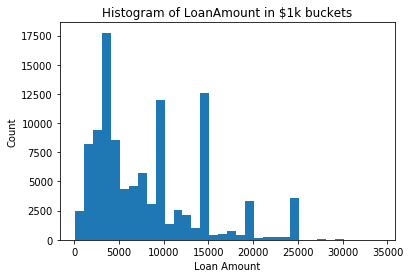

In [39]:
la = plt.hist(loans['LoanOriginalAmount'], bins=np.arange(100,35000,1000))
plt.xlabel('Loan Amount')
plt.ylabel('Count')
plt.title('Histogram of LoanAmount in $1k buckets');

In [40]:
# Create a new df with loans that aren't complete
loans_default = loans[loans['LoanStatus'] != 'Completed']
loans_default = loans_default[loans_default['LoanStatus'] != 'FinalPaymentInProgress']
loans_default['LoanStatus'].value_counts()

Current                   56566
Chargedoff                10632
Defaulted                  3289
Past Due (1-15 days)        806
Past Due (31-60 days)       363
Past Due (61-90 days)       313
Past Due (91-120 days)      304
Past Due (16-30 days)       265
Past Due (>120 days)         16
Cancelled                     1
Name: LoanStatus, dtype: int64

In [41]:
# Change all Current as 1 and anything else as 0
loans_default['LoanStatus'] = (loans_default['LoanStatus'] == "Current").astype(int)
loans_default.LoanStatus.unique()

array([1, 0], dtype=int64)

#### 77.9 percent of active loans are not in a default status, leaving the remaining 22.1% deliquent. Lets look into where some of these deliquent loans are coming from.

## LoanStatus by ListingCategory

> Loans taken out for Personal, Student, or where the use was Unknown were 100% in default status. This would tell me, loans of those types are very risky to fund. Where loans for RV's and Motorcycles are much more likely to be current.

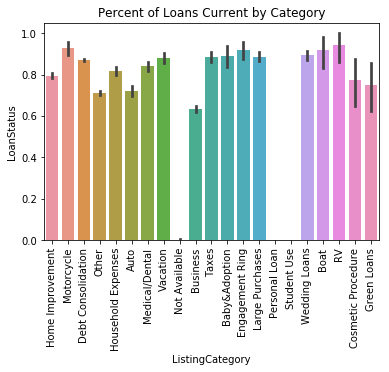

In [42]:
sns.barplot(x='ListingCategory', y='LoanStatus', data=loans_default)
plt.title('Percent of Loans Current by Category')
plt.xticks(rotation=90);

## LoanStatus by ProsperScore
> How well do loans do based on the Score Prosper gives the applicant. Here we can see that only half of the applicants with a score of 6, which also held the majority of loans are curent on their loans. The highest scores have a higher rate of being current, where the lowest score (1) has a lower rate, while not the lowest.

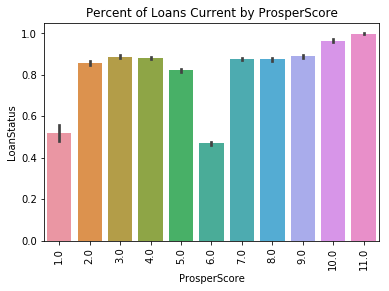

In [44]:
sns.barplot(x='ProsperScore', y='LoanStatus', data=loans_default)
plt.title('Percent of Loans Current by ProsperScore')
plt.xticks(rotation=90);

## LoanStatus in Relation to LoanAmount and Borrower APR
> In these charts we can see that we have a larger number of loans in the smaller loan amounts <5k that are in default then current. And loans that are current seem to have a higher freq of loans in the 10k and 15k range then loans that are in default. The same can be said for BorrowerAPR, loans that have a higher rate, more risky, tend to default more often, then those with a lower APR.

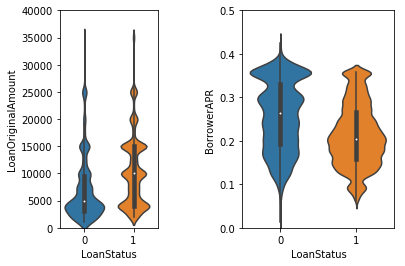

In [54]:
fig = plt.figure()
ax1 = fig.add_subplot(131)
sns.violinplot(x='LoanStatus', y='LoanOriginalAmount', data=loans_default).set_ylim([0,40000])

ax2 = fig.add_subplot(122)
sns.violinplot(x='LoanStatus', y='BorrowerAPR', data=loans_default).set_ylim([0,.50]);

## Sankey Diagram of Score to Status to ListingCategory.
> I find this diagram to show a nice representation of loans. Here we can see that the largest number of loans tend to come from ProsperScores of 6, And if we follow the split we can see that over 53% of them are in Default. We can then see of the loans in default that 40% of them were for Debt Consolidation. As an investor, you might want to invest in loans that aren't for Debt Consolidation. 

In [55]:
# Lets create two new dataframes by grouping some categories together and finding the counts in each. This will be used later
# to create the chart.
df1 = loans_default.groupby(['ProsperScore', 'LoanStatus']).size().reset_index(name='counts')
df2 = loans_default.groupby(['LoanStatus', 'ListingCategory']).size().reset_index(name='counts')

In [56]:
# Now we need to create an empty list that we can fill with some dictionaries, and a dict of colors for the different categories.
# Then we can loop through the dataframes we created eariler adding them to the links list as dicts.
links = []
colors = {'Cur': 'steelblue', 'Def':'indianred', 1:'maroon', 2:'darkred', 3:'red', 4:'gold', 5:'olive', 6:'yellow', 7:'lime', 8:'limegreen', 9:'forestgreen', 10:'green', 11:'darkgreen'}
for index, row in df1.iterrows():
    if row['LoanStatus'] == 1:
        links.append({'source': row['ProsperScore'], 'target': 'Cur', 'value': row['counts'], 'color':colors[row['ProsperScore']]})
    else:
        links.append({'source': row['ProsperScore'], 'target': 'Def', 'value': row['counts'], 'color':colors[row['ProsperScore']]})
        
        
for index, row in df2.iterrows():
    if row['LoanStatus'] == 1:
        links.append({'source': 'Cur', 'target': row['ListingCategory'], 'value': row['counts'], 'color':colors['Cur']})
    else:
        links.append({'source': 'Def', 'target': row['ListingCategory'], 'value': row['counts'], 'color':colors['Def']})

In [57]:
# Create the Sankey Diagram, order defines the sort order, groups helps to identify which column is being ploted
from ipysankeywidget import SankeyWidget
from ipywidgets import Layout

layout = Layout(width="1000", height="1200")
def sankey(margin_top=10, **value):
    """Show SankeyWidget with default values for size and margins"""
    return SankeyWidget(layout=layout,
                        margins=dict(top=margin_top, bottom=0, left=20, right=100),
                        **value)
order = [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], ['Cur', 'Def'], loans_default.ListingCategory.tolist()]
groups = [{'id': 'A', 'title': 'ProsperScore', 'nodes': loans_default.ProsperScore.tolist()},
         {'id': 'B', 'title': 'LoanStatus', 'nodes': ['Cur', 'Def']},
         {'id': 'C', 'title': 'ListingCategory', 'nodes': loans_default.ListingCategory.tolist()}]
sankey(links=links, order=order, linkLabelFormat='.1f', groups=groups).auto_save_png('sankey.png')

SankeyWidget(groups=[{'id': 'A', 'title': 'ProsperScore', 'nodes': [7.0, 9.0, 4.0, 10.0, 2.0, 4.0, 9.0, 11.0, …

In [58]:
%%html
<img src="sankey.png" />

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!